#### 遥感图像通常很大，要对图像进行切割，并保存，可若是将图像切割后保存为图像，这样会很占内存，可以直接保存图像的numpy数组。对于mask图像，我们通常要把它转换为one_hot形式，本次实验的数据是23分类，可若是将mask保存为（None,224,224,23）太占内存，所以在保存mask的时候，我们保存的是(None,224,224)的形式，其中像素值是0~22，每个位置的像素值代表这个像素的类别。

In [52]:

import numpy as np
import os
# from libtiff import TIFF
from skimage import io

unit_width = 224  # 每个小图片的长和宽（正方形）
file_dir = '/input0/4bands/'

def readTif(file_name, isMask=False):
    '''
    读取一张tif格式的图片，返回图片的宽、高、通道数目、图片的array
    注：用io.imread()读取tif和用
    '''
    image=io.imread(file_dir+file_name)
    im_width = image.shape[1]
    im_height = image.shape[0]
    im_bands = 1
    if not isMask:
        im_width = image.shape[1]
        im_height = image.shape[0]
        im_bands = image.shape[2]
        image = image.swapaxes(0, 2)
        im_data = image.swapaxes(1, 2)
        image = im_data
#     print('readtif: image.shape',image.shape) #(4,3953,2833)(通道，高，宽) mask:(3952,2832)(高，宽)
    return {'width': im_width, 'height': im_height, 'band_num': im_bands, 'data': image}


def divide(img, mask, size, stride):
    #输入的图片是一张遥感大图,宽高分别以stride为步长，进行divide,如果size=224,stride=100,则每次以100为步长
    #将图片切割成（224,224）大小,当stride<size时，切割的图片是有重叠部分的，size越小，重叠的部分越多，当stride>size时，
    #切割的部分没有重叠，而且图片的有些部分甚至没有被保留下来
    #size:224,stride:100
    #img['data'].shape:(4,3953,2833)
    imgs, labels = [], []
    bands, height, width = img['band_num'], img['height'], img['width']
#     print('height',height,'stride',stride,'width',width)
#     print("img['data'].shape",img['data'].shape)#(4,3953,2833)
    for row in range(0, height, stride):
        for col in range(0, width, stride):
            if row + size > height or col + size > width:
                continue
            feature = []
            for band_id in range(bands):
                #feature里面apppend的大小是（224,224）
                feature.append(img['data'][band_id, row:row + size, col:col + size])
#                 print('2',img['data'][band_id, row:row + size, col:col + size].shape)

            label = mask['data'][row:row + size, col: col + size]
            imgs.append(feature)
            labels.append(label)

    imgs=np.array(imgs)
#     print('divide:','imgs.shape',imgs.shape)
    return imgs, labels


def get_data():
    '''
    输入的是所有images和mask的名字，返回的是经过切割后的数组（None,bands,224,224）,(None,224,224)
    '''
    img_names=['%02d.tif'%i for i in range(1,15)]
    mask_names=['%02d_mask.tif'%i for i in range(1,15)]
    print(img_names)
    xs, ys = [], []
    for (img, mask) in zip(img_names, mask_names):
        img = readTif(img)
        mask = readTif(mask, True)
        imgs, labels = divide(img, mask, 224,100)  # 后两个参数为图片尺寸和步长
        for img, label in zip(imgs, labels):
            xs.append(img)
            ys.append(label)
    xs=np.array(xs)
    ys=np.array(ys)
    return xs, ys


xs, ys = get_data()
print(xs.shape,ys.shape)

['01.tif', '02.tif', '03.tif', '04.tif', '05.tif', '06.tif', '07.tif', '08.tif', '09.tif', '10.tif', '11.tif', '12.tif', '13.tif', '14.tif']


/usr/local/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2579: UserWarning: invalid tile data
  warnings.warn("invalid tile data")
/usr/local/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2546: UserWarning: unpack: string size must be a multiple of element size
  warnings.warn("unpack: %s" % e)


(7049, 4, 224, 224) (7049, 224, 224)


In [54]:
# orishape = ys.shape

#(None*224*224,)
#首先将mask转化为一维的数组，unique_num是value和索引对，比如mask里面原来有一个像素为3，给它分配一个索引0，然后将二维的mask转换为
# 索引后的数组,eg：如果里面是23分类，则mask已经转化为里面的元素只有0～22的数组
# ys = ys.reshape(-1)
# unique_num = {v: i for i, v in enumerate(np.unique(ys))}
# for i, v in enumerate(ys):
#     ys[i] = unique_num[v]
# ys = ys.reshape(orishape)

#pi会返回一个数组，这个数组里面的数<xs.shape[0]，然后可以根据pi打乱xs和ys数组里面的排序
pi = np.random.permutation(xs.shape[0])
xs, ys = xs[pi], ys[pi]
bound = int(len(ys)*0.9)
np.save('./data/train_image.npy', xs)
np.save('./data/train_annotation.npy', ys)
np.save('./data/validation_image.npy', xs[bound:])
np.save('./data/validation_annotation.npy', ys[bound:])

train_mask=np.load('./data/train_annotation.npy')
print('train_mask.shape',train_mask.shape)

train_mask.shape (7049, 224, 224)


(224, 224) [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16]


True

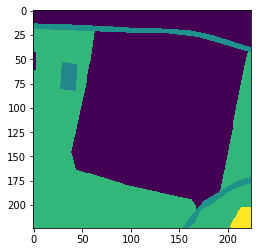

In [51]:
import  matplotlib.pyplot as plt


img1=ys[19,:,:]
print(img1.shape,img1[0,:])
plt.imshow(img1)
cv2.imwrite('./10.png',img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


True

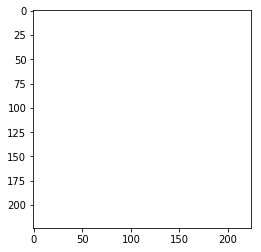

In [48]:
import cv2
img=xs.swapaxes(1,2).swapaxes(2,3)
img=img/np.max(img)*255.
# img.shape
img2=img[19,:,:,:3]
print(img2.shape)
plt.imshow(img2)
# print(img2)
# np.max(img)
# img
cv2.imwrite('./10.jpg',img2)

In [27]:
ys=ys.reshape(-1)
unique_num = {v: i for i, v in enumerate(np.unique(ys))}
print(unique_num)

{15: 0, 16: 1, 17: 2, 21: 3, 23: 4, 24: 5, 30: 6, 41: 7, 42: 8, 43: 9, 45: 10, 46: 11, 50: 12, 54: 13, 65: 14, 90: 15}


In [ ]:
orishape = ys.shape

#(None*224*224,)
#首先将mask转化为一维的数组，unique_num是value和索引对，比如mask里面原来有一个像素为3，给它分配一个索引0，然后将二维的mask转换为
# 索引后的数组,eg：如果里面是23分类，则mask已经转化为里面的元素只有0～22的数组
ys = ys.reshape(-1)
unique_num = {v: i for i, v in enumerate(np.unique(ys))}
for i, v in enumerate(ys):
    ys[i] = unique_num[v]
ys = ys.reshape(orishape)

#pi会返回一个数组，这个数组里面的数<xs.shape[0]，然后可以根据pi打乱xs和ys数组里面的排序
pi = np.random.permutation(xs.shape[0])
xs, ys = xs[pi], ys[pi]
bound = int(len(ys)*0.9)
np.save('./data2/train_image.npy', xs[:bound])
np.save('./data2/train_annotation.npy', ys[:bound])
np.save('./data2/validation_image.npy', xs[bound:])
np.save('./data2/validation_annotation.npy', ys[bound:])

train_mask=np.load('./data2/train_annotation.npy')
print('train_mask.shape',train_mask.shape

In [ ]:
# coding:utf-8
import numpy as np
import cv2
import tensorflow as tf
# from libtiff import TIFF
import matplotlib.pyplot as plt
from skimage import io
img_size = 224

file_dir = './all_images/'


def get_mask(imgs):
    #输入测试图片的array，返回模型预测的array
    imgs = imgs.swapaxes(1, 2).swapaxes(2, 3)
    masks = []
    for img in imgs:
        img = np.expand_dims(img, axis=0)
        mask = deeplab_model.predict([img])
        masks.append(mask)
    return np.array(masks)


# import gdal
def readTif(file_name, isMask=False):
    #读取tif图片
#     tif = TIFF.open(file_dir + file_name)

#     image = tif.read_image()
    image=io.imread(file_dir+file_name)
    im_width = image.shape[1]
    im_height = image.shape[0]
    im_bands = 1
    if not isMask:
        im_width = image.shape[1]
        im_height = image.shape[0]
        im_bands = image.shape[2]
        image = image.swapaxes(0, 2)
        im_data = image.swapaxes(1, 2)
        image = im_data

    return {'width': im_width, 'height': im_height, 'band_num': im_bands, 'data': image}


def divide(img):
    #切割图片，同制作数据时的切割不同，现在的切割是无缝无重叠的切割
    imgs = np.array([])
    bands, height, width = img.shape
    for row in range(0, height, img_size):
        for col in range(0, width, img_size):
            if row + img_size >= height:
                row = height - img_size - 1
            if col + img_size >= width:
                col = width - img_size - 1
            imgs = np.append(imgs, img[:, row:row + img_size, col:col + img_size])
    imgs = imgs.reshape([-1, 4, 224, 224])

    return imgs


def union(imgs, height, width):
    img = np.zeros((height, width))
    id = 0
    for row in range(0, height, img_size):
        for col in range(0, width, img_size):
            if row + img_size >= height:
                row = height - img_size - 1
            if col + img_size >= width:
                col = width - img_size - 1
            img[row:row + img_size, col:col + img_size] = imgs[id]
            id += 1
    return img
